# Tree, bagging et forêts aléatoires

## Simulation

Soit X un vecteur gaussien de loi $\mathcal N_p(\boldsymbol \mu, \boldsymbol \Sigma)$

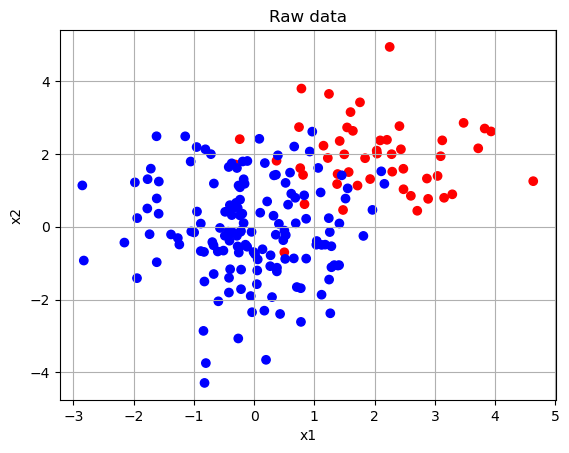

In [8]:
import random as rd
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math

NG1, NG2 = 50, 150
mu1 = [2, 2]  # Moyenne G1
cov1 = [[1, 0], [0, 1]]  # Matrice de covariance G1 (indépendance)
    
mu2 = [0, 0]  # Moyenne G2
cov2 = [[1, 0], [0, 2]]  # Matrice de covariance G2 (indépendance mais variance différente)
    
# Génération des données
xG1 = multivariate_normal(mean=mu1, cov=cov1).rvs(NG1)
xG2 = multivariate_normal(mean=mu2, cov=cov2).rvs(NG2)
    
X = np.concatenate((xG1, xG2), axis=0)
Y = [0] * NG1 + [1] * NG2


# Visualisation des données générées
mycolormap = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=mycolormap)
plt.title('Raw data')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Classification avec arbre de décision


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialiser le classificateur
dt_classifier = DecisionTreeClassifier()

# Entraîner le modèle
dt_classifier.fit(X, Y)

# Prédire les probabilités sur le jeu d'entraînement
pred_proba_train = dt_classifier.predict_proba(X)

# Obtenir les prédictions des classes
pred_class_train = np.argmax(pred_proba_train, axis=1)

# Calculer l'accuracy sur le jeu d'entraînement
train_accuracy = accuracy_score(Y, pred_class_train)

# Afficher l'erreur d'entraînement
train_error = 1 - train_accuracy
print(f"Erreur sur l'ensemble d'entraînement : {train_error:.2f}")


Erreur sur l'ensemble d'entraînement : 0.00


### Tracé de la frontière de décision avec contourf

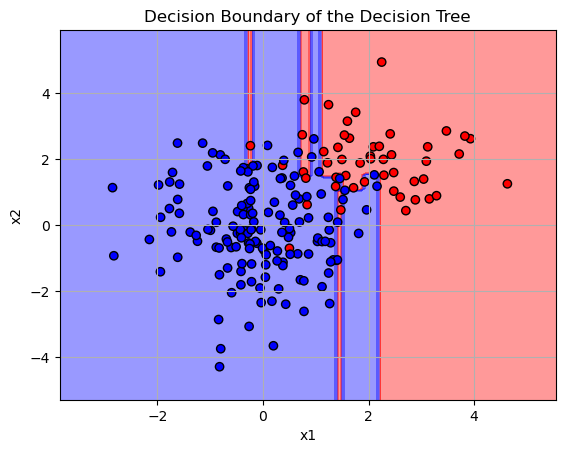

In [10]:
# ---- Traçage de la frontière de décision ----
# Créer une grille de points couvrant l'espace des données
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Prédire la classe pour chaque point de la grille
Z = dt_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer la frontière de décision avec contourf
plt.contourf(xx, yy, Z, alpha=0.4, cmap=mycolormap)

# Tracer les points de données
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=mycolormap)
plt.title('Decision Boundary of the Decision Tree')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [11]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)
 |
 |  A decision tree classifier.
 |
 |  Read more in the :ref:`User Guide <tree>`.
 |
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy", "log_loss"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "log_loss" and "entropy" both for the
 |      Shannon information gain, see :ref:`tree_mathematical_formulation`.
 |
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies ar

Les paramètres de l'arbre de décision sont fixés mais peuvent être changés. Pour obtenir un arbre plus simple, il est par exemple possible d'augmenter le nombre de noeuds minimum par feuille.

In [12]:
dt_classifier = DecisionTreeClassifier()

# Afficher les paramètres du modèle
params = dt_classifier.get_params()
print(params)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


In [17]:
dt_classifier.set_params(min_samples_split= 30)

DecisionTreeClassifier(min_samples_split=30)

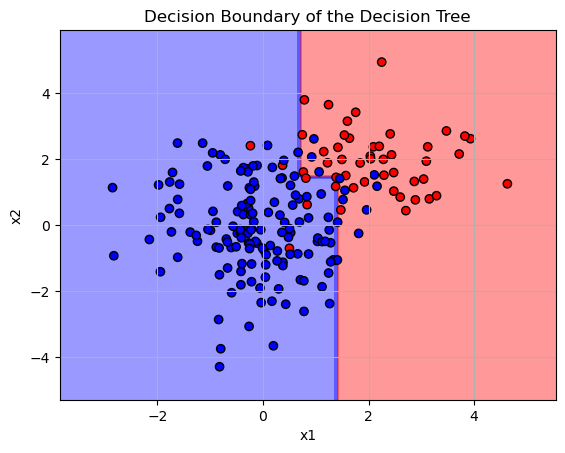

In [18]:
# Entraîner le modèle
dt_classifier.fit(X, Y)
Z = dt_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer la frontière de décision avec contourf
plt.contourf(xx, yy, Z, alpha=0.4, cmap=mycolormap)

# Tracer les points de données
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=mycolormap)
plt.title('Decision Boundary of the Decision Tree')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()



### La méthode CART avec l'élagage pour obtenir les valeurs de coût-complexité

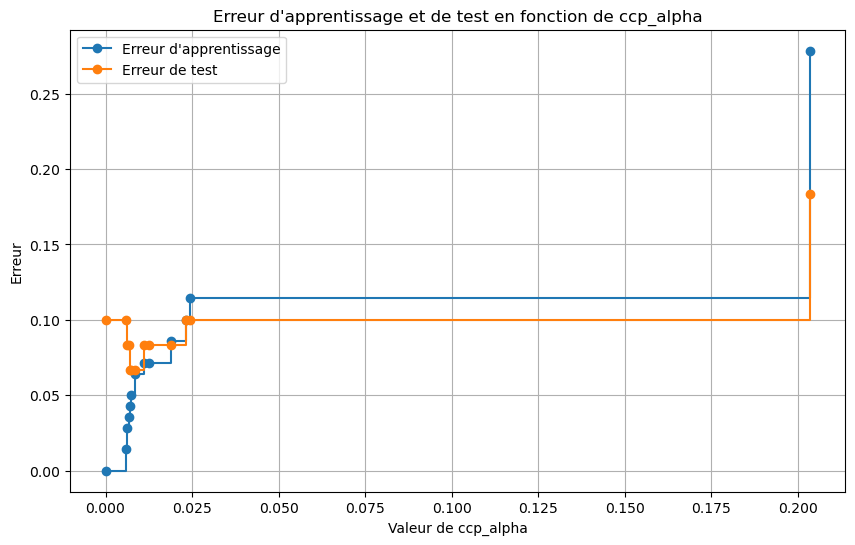

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Générer des données exemple (X, Y) - Tes données
# Assure-toi d'avoir X et Y définis avant ceci
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

# Initialiser le classificateur sans élagage pour obtenir le chemin d'élagage
dt_classifier = DecisionTreeClassifier(random_state=1)
path = dt_classifier.cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas  # Liste des valeurs de ccp_alpha
impurities = path.impurities  # Coût total de l'arbre pour chaque alpha

# Stocker les erreurs pour chaque ccp_alpha
train_errors = []
test_errors = []

# Entraîner un arbre pour chaque valeur de ccp_alpha et calculer les erreurs
for ccp_alpha in ccp_alphas:
    dt_classifier_pruned = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    dt_classifier_pruned.fit(X_train, Y_train)
    
    # Prédiction sur l'ensemble d'entraînement et de test
    train_pred = dt_classifier_pruned.predict(X_train)
    test_pred = dt_classifier_pruned.predict(X_test)
    
    # Calculer l'erreur (1 - précision)
    train_error = 1 - accuracy_score(Y_train, train_pred)
    test_error = 1 - accuracy_score(Y_test, test_pred)
    
    # Stocker les erreurs
    train_errors.append(train_error)
    test_errors.append(test_error)

# Tracer les erreurs d'apprentissage et de test en fonction de ccp_alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_errors, marker='o', label="Erreur d'apprentissage", drawstyle="steps-post")
plt.plot(ccp_alphas, test_errors, marker='o', label="Erreur de test", drawstyle="steps-post")
plt.xlabel("Valeur de ccp_alpha")
plt.ylabel("Erreur")
plt.title("Erreur d'apprentissage et de test en fonction de ccp_alpha")
plt.legend()
plt.grid(True)
plt.show()


## Bagging


L'erreur en apprentissage du Bagging est  0.0


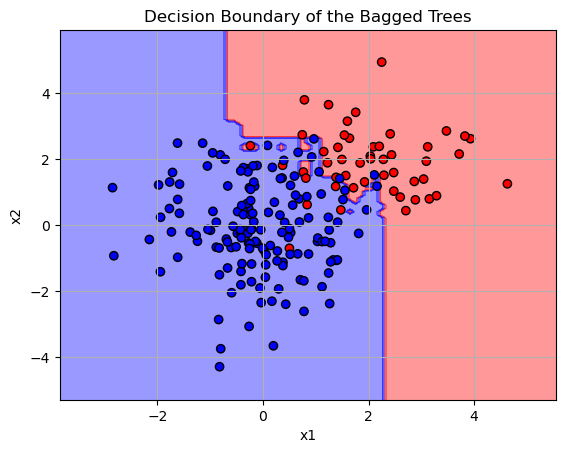

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# Initialiser le modèle d'arbre de décision
treemod = DecisionTreeClassifier()

# Initialiser le modèle Bagging avec l'arbre de décision comme estimateur de base
bagmod = BaggingClassifier(estimator=treemod, n_estimators=100, random_state=0)

# Entraîner les modèles (arbre et bagging) sur les données
treemodfit = treemod.fit(X, Y)  # Facultatif ici si tu utilises le modèle bagging
bagmodfit = bagmod.fit(X, Y)

# Prédire les classes sur l'ensemble d'entraînement avec Bagging
pY_train = bagmodfit.predict(X)  # Utiliser predict() pour obtenir les classes

# Calculer l'erreur d'entraînement
train_error = 1 - accuracy_score(Y, pY_train)
print("L'erreur en apprentissage du Bagging est ", train_error)


Z = bagmodfit.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer la frontière de décision avec contourf
plt.contourf(xx, yy, Z, alpha=0.4, cmap=mycolormap)

# Tracer les points de données
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=mycolormap)
plt.title('Decision Boundary of the Bagged Trees')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()


## Forêt aléatoire

L'erreur en apprentissage de la forêt aléatoire est  0.0


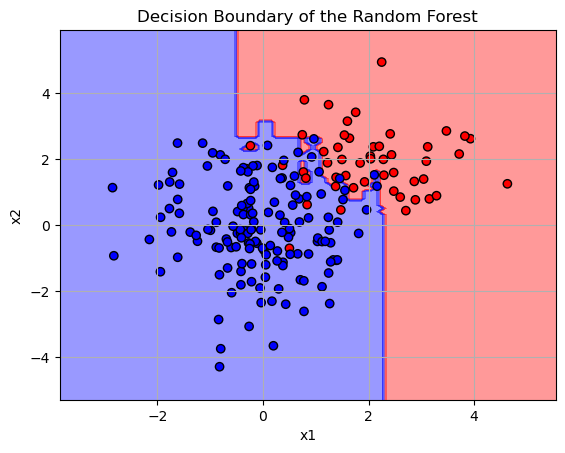

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Remplace le BaggingClassifier par le RandomForestClassifier
forestmod = RandomForestClassifier(n_estimators=100, random_state=0)

# Entraîner le modèle de forêt aléatoire sur les données
forestmodfit = forestmod.fit(X, Y)

# Prédire les classes sur l'ensemble d'entraînement avec RandomForest
pY_train = forestmodfit.predict(X)

# Calculer l'erreur d'entraînement
train_error = 1 - accuracy_score(Y, pY_train)
print("L'erreur en apprentissage de la forêt aléatoire est ", train_error)


# Prédire les classes sur la grille de points avec RandomForest
Z = forestmodfit.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Tracer la frontière de décision avec contourf
mycolormap = ListedColormap(['#FF0000', '#0000FF'])
plt.contourf(xx, yy, Z, alpha=0.4, cmap=mycolormap)

# Tracer les points de données
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=mycolormap)
plt.title('Decision Boundary of the Random Forest')
plt.grid()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()
